In [22]:
import json
from os.path import join

import numpy as np
import pandas as pd
from dn_utils.path import path
from dn_utils.style import lighten_color, POWER_COLORS, ORANGE, BLUE
import plotly.graph_objects as go

In [3]:
atlas = "combined_roi"
gamma_range = np.arange(0.5, 2.5, 0.5)

In [61]:
# Load consensus partitions
path_corrmats = join(path["bsc"], "corrmats")
path_corrmats_unthr = join(path_corrmats, atlas, "unthr")

consensus = {}
for gamma in gamma_range: 
    gamma_str = str(float(gamma)).replace(".", "_")
    path_corrmats_unthr_gamma = join(path_corrmats_unthr, f"gamma_{gamma_str}")
    
    with open(join(path_corrmats_unthr_gamma, 
                   "consensus_tau_0_5.json"), "r") as f:
        consensus[gamma] = json.load(f)
        
# Load reference partition 
df_roi = pd.read_csv(
    join(path_corrmats, atlas, "roi_table_filtered.csv"))    

# Fix Power ROI colors
if any(c[0] != "#" for c in df_roi["netColor"]):
    df_roi["netColor"] = df_roi["netColor"].map(
        {cname: lighten_color(c, .2) for cname, c in POWER_COLORS.items()}, 
        na_action="ignore")
    df_roi.loc[df_roi["netName"] == "perr_inc", "netColor"] = ORANGE
    df_roi.loc[df_roi["netName"] == "perr_dec", "netColor"] = BLUE

In [150]:
def create_netname(net_idx):
    return f"net_{int(net_idx)}"

def create_sankey_kwargs(m, source_networks, source_colors, link_cmap={}):
    """Create arguments for Sankey diagram from plotly.
    
    m (np.array):
        Target community division.
    source_networks (np.array):
        Source community division. Usually a priori networks from metanalysis.
    source_colors (list-like):
        Colors corresponding to each ROI in source_networks vector.
    link_cmap (dict):
        Colors for connections linking specific network from source_networks to
        regions in m. Key should correspond to network name and value to valid
        matplotlib color. 
    """
    # Convert numbers to names
    m = pd.Series(m)
    m = m.map({net_idx: create_netname(net_idx) for net_idx in m.unique()})

    # Create plotly nodes
    source_netnames = np.unique(source_networks)
    n_sources = len(source_netnames)
    target_netnames = m.unique()
    n_targets = len(target_netnames)
    
    # Node colors
    source_netcolors = [source_colors[source_networks == network].iloc[0] 
                        for network in source_netnames]
    target_netcolors = ["gray"] * n_targets

    node_labels = list(source_netnames) + list(target_netnames)
    node_colors = source_netcolors + target_netcolors

    source, target, value, link_colors = [], [], [], []

    for target_net in target_netnames:
        for source_net, links in source_networks[np.array(m == target_net)].value_counts().items():
            source.append(node_labels.index(source_net))
            target.append(node_labels.index(target_net))
            value.append(links)
            if source_net in link_cmap:
                link_colors.append(link_cmap[source_net])
            else:
                link_colors.append("rgba(0, 0, 0, 0.2)")            

    node_kwargs = dict(label=node_labels, color=node_colors)
    link_kwargs = dict(source=source, target=target, value=value, color=link_colors)

    return node_kwargs, link_kwargs

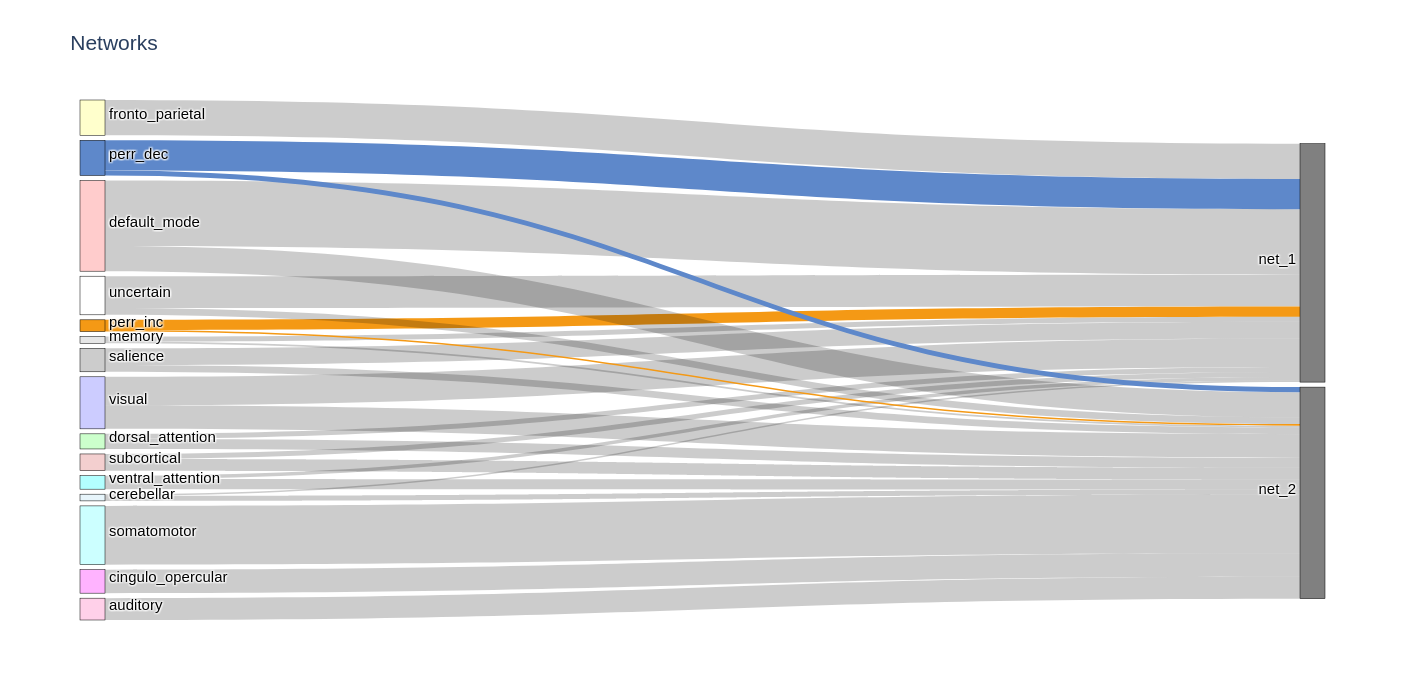

In [151]:
node_kwargs, link_kwargs = create_sankey_kwargs(
    consensus[0.5]["all"], 
    df_roi["netName"], 
    df_roi["netColor"], 
    link_cmap = {"perr_inc": ORANGE, "perr_dec": BLUE}
)

fig = go.Figure(data=[go.Sankey(
    node={
        "pad": 5, 
        "thickness": 25, 
        "line": {"color": "black", "width": 0.5},
        **node_kwargs
    },
    link=link_kwargs
)]) 
    
fig.update_layout(title_text="Networks", font_size=15, width=800, height=700)
fig.show()

In [100]:
mr = df_roi["netName"]
ma = pd.Series(consensus[0.5]["inc"]) # CREATE STRINGS
mb = pd.Series(consensus[0.5]["dec"])

In [74]:
from itertools import product

In [154]:
def communities_overlap(m1, m2):
    """Calculate overlap matrix between two community vectors."""
    
    if len(m1) != len(m2): 
        raise ValueError(
            f"m1 and m2 should have equal length ({len(m1)} != {len(m2)}) ")
    if (ma.index != mb.index).any():
            f"m1 and m2 should have consistent index"

    m1_unique = m1.unique()
    m2_unique = m2.unique()

    df = pd.DataFrame(index=m1_unique, columns=m2_unique)
    for c in m2_unique:
        df[c] = m1[m2 == c].value_counts()        
    df = df.fillna(0)

    return df.astype(int)

In [155]:
ms = [ma, mr, mb]
unique = [m.unique() for m in ms]
...